<h1>Imports
<!--
    Referenced and followed along with the following notebooks:
    https://www.kaggle.com/muhakabartay/ingv-volcano-eda-with-lgbm#Data
    https://www.kaggle.com/isaienkov/ingv-volcanic-eruption-prediction-eda-modeling/comments
-->

In [3]:
import pandas as pd
import numpy as np 
import pandas as pd
import os
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from lightgbm import LGBMRegressor
from xgboost import XGBRegressor
import glob


<h1>Read the data 

In [78]:
train = pd.read_csv('../data/train.csv')
sampleSub = pd.read_csv('../data/sample_submission.csv')
trainSensors = glob.glob('../data/train/*')
testSensors = glob.glob('../data/test/*')

testFiles = []
trainFiles = []

for fileName in trainSensors:
    trainFiles.append(fileName[14:-4])

for fileName in testSensors:
    testFiles.append(fileName[14:-4])

test = pd.DataFrame(testFiles, columns=["segment_id"])

print('Train files: {}'.format(len(trainFiles)))
print('Test files: {}'.format(len(testFiles)))

Train files: 4431
Test files: 4520


In [29]:
print(train)

      segment_id  time_to_eruption
0     1136037770          12262005
1     1969647810          32739612
2     1895879680          14965999
3     2068207140          26469720
4      192955606          31072429
...          ...               ...
4426   873340274          15695097
4427  1297437712          35659379
4428   694853998          31206935
4429  1886987043           9598270
4430  1100632800          20128938

[4431 rows x 2 columns]


In [30]:
print(test)

     segment_id
0     000213997
1      00023368
2     000488999
3     001028887
4     001857862
...         ...
4515   96704281
4516   97630809
4517   98072137
4518   98136924
4519    9975682

[4520 rows x 1 columns]


In [32]:
display(train.sort_values('time_to_eruption', axis=0, ascending=True).iloc[[0,-1],:])
# print(pd.read_csv('../data/train/'+'601524801'+'.csv'))

segment_id  time_to_eruption
590    601524801              6250
1139  1923243961          49046087

In [44]:
minSegment = pd.read_csv('../data/train/601524801.csv')
maxSegment = pd.read_csv('../data/train/1923243961.csv')

minSegment.head()

sensor_1  sensor_2  sensor_3  sensor_4  sensor_5  sensor_6  sensor_7  \
0    -466.0       NaN       NaN    -358.0    -244.0      -6.0    -130.0   
1    -393.0       NaN       NaN    -208.0    -298.0      -9.0    -102.0   
2    -361.0       NaN       NaN    -503.0    -334.0    -164.0     -63.0   
3    -492.0       NaN       NaN    -789.0     -64.0    -199.0      28.0   
4    -592.0       NaN       NaN    -814.0      54.0     -73.0      58.0   

   sensor_8  sensor_9  sensor_10  
0       NaN     390.0     -461.0  
1       NaN    -212.0    -1514.0  
2       NaN      89.0     -772.0  
3       NaN      77.0      610.0  
4       NaN    -459.0       47.0

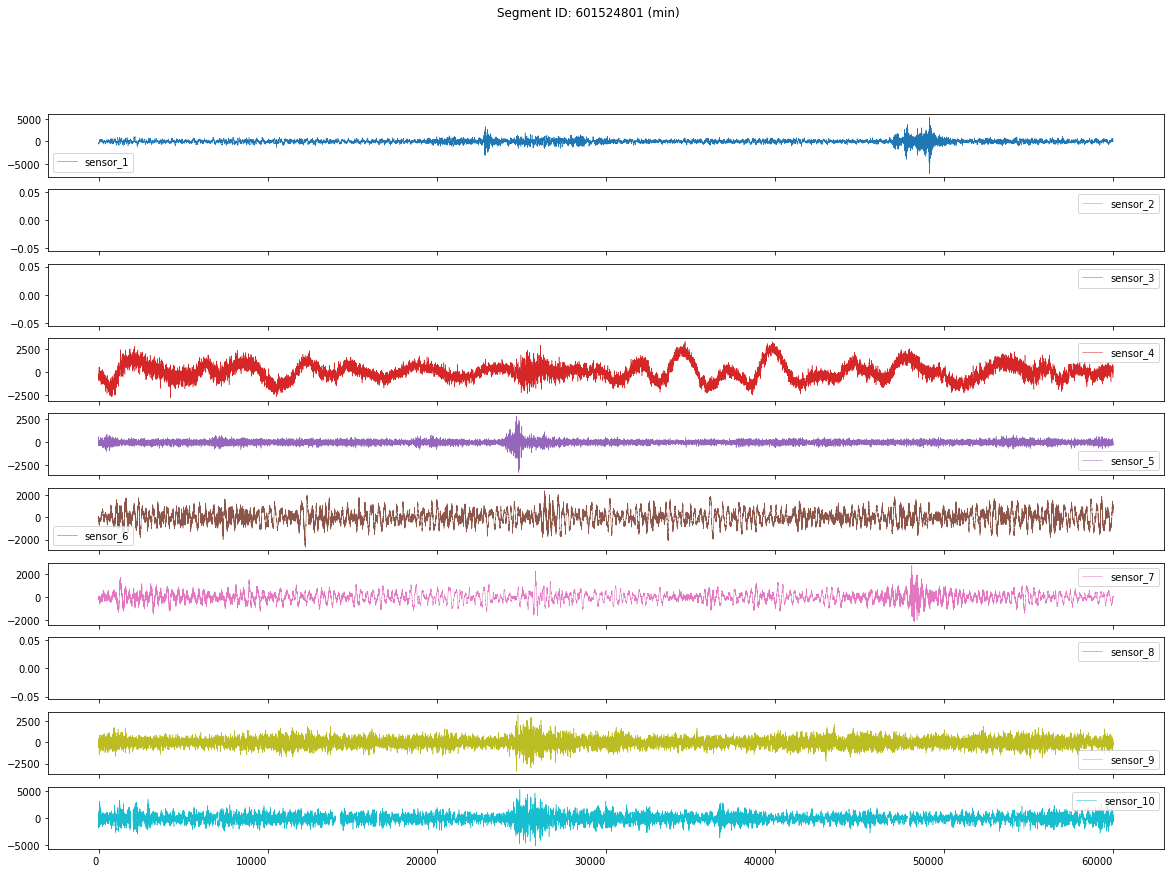

In [76]:
minSegment.plot(figsize=(20,15),
                subplots=True, 
                layout=(10,1),
                rot=0, 
                lw=0.5,
                title='Segment ID: 601524801 (min)'
                )
plt.show()

In [60]:
maxSegment.head()

sensor_1  sensor_2  sensor_3  sensor_4  sensor_5  sensor_6  sensor_7  \
0       NaN   -2111.0     331.0    -327.0       NaN     214.0     277.0   
1       NaN   -1987.0     300.0    -359.0       NaN     187.0     263.0   
2       NaN   -1493.0     253.0    -363.0       NaN     217.0     264.0   
3       NaN    -841.0     227.0    -342.0       NaN     265.0     261.0   
4       NaN    -309.0     200.0    -304.0       NaN     230.0     258.0   

   sensor_8  sensor_9  sensor_10  
0     -24.0     486.0      644.0  
1    -164.0     446.0      833.0  
2    -158.0     375.0      991.0  
3    -175.0     280.0     1077.0  
4    -216.0     239.0     1125.0

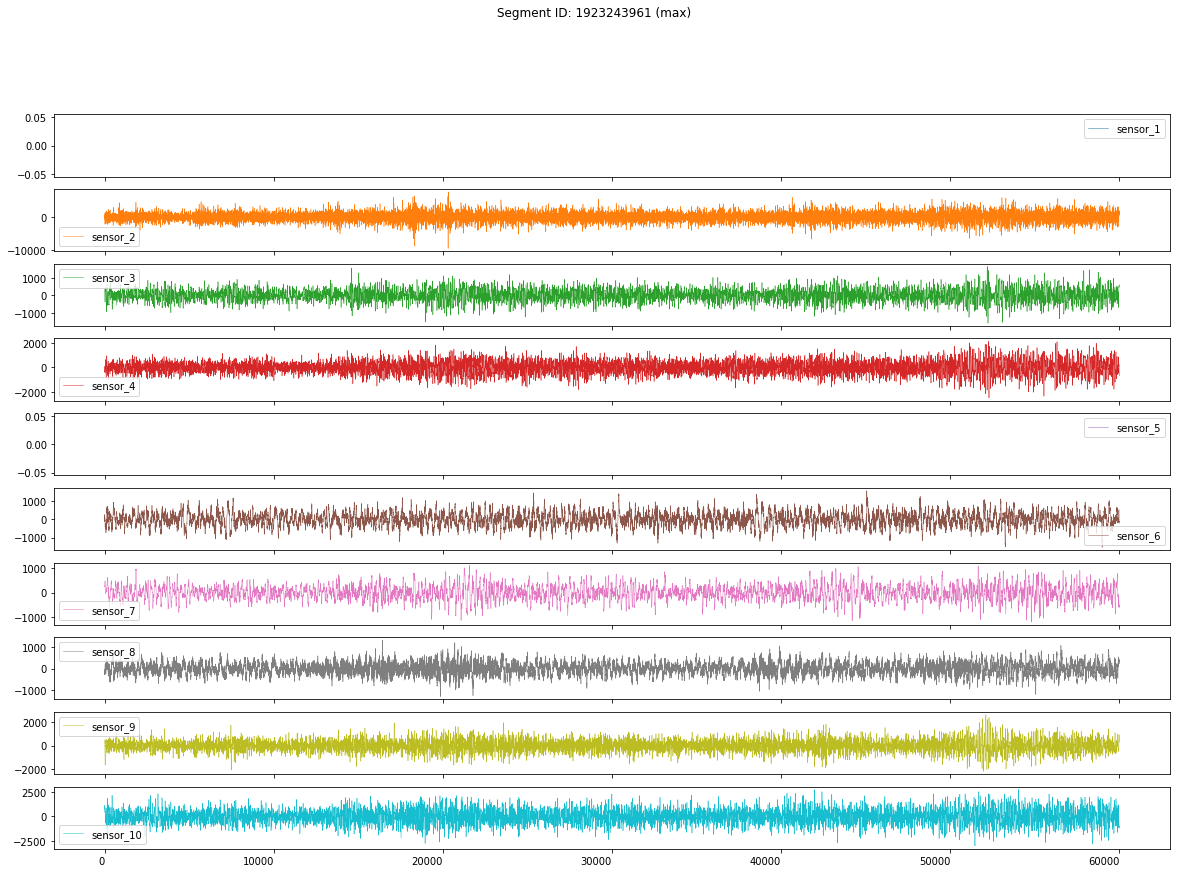

In [75]:
maxSegment.plot(figsize=(20,15),
                subplots=True, 
                layout=(10,1),
                rot=0, 
                lw=0.5,
                title='Segment ID: 1923243961 (max)'
                )
plt.show()

<h1> Create the model

In [77]:
def build_features(signal, ts, sensor_id):
    X = pd.DataFrame()
    f = np.fft.fft(signal)
    f_real = np.real(f)
    X.loc[ts, f'{sensor_id}_sum']       = signal.sum()
    X.loc[ts, f'{sensor_id}_mean']      = signal.mean()
    X.loc[ts, f'{sensor_id}_std']       = signal.std()
    X.loc[ts, f'{sensor_id}_var']       = signal.var() 
    X.loc[ts, f'{sensor_id}_max']       = signal.max()
    X.loc[ts, f'{sensor_id}_min']       = signal.min()
    X.loc[ts, f'{sensor_id}_skew']      = signal.skew()
    X.loc[ts, f'{sensor_id}_mad']       = signal.mad()
    X.loc[ts, f'{sensor_id}_kurtosis']  = signal.kurtosis()
    X.loc[ts, f'{sensor_id}_quantile99']= np.quantile(signal, 0.99)
    X.loc[ts, f'{sensor_id}_quantile95']= np.quantile(signal, 0.95)
    X.loc[ts, f'{sensor_id}_quantile85']= np.quantile(signal, 0.85)
    X.loc[ts, f'{sensor_id}_quantile75']= np.quantile(signal, 0.75)
    X.loc[ts, f'{sensor_id}_quantile55']= np.quantile(signal, 0.55)
    X.loc[ts, f'{sensor_id}_quantile45']= np.quantile(signal, 0.45) 
    X.loc[ts, f'{sensor_id}_quantile25']= np.quantile(signal, 0.25) 
    X.loc[ts, f'{sensor_id}_quantile15']= np.quantile(signal, 0.15) 
    X.loc[ts, f'{sensor_id}_quantile05']= np.quantile(signal, 0.05)
    X.loc[ts, f'{sensor_id}_quantile01']= np.quantile(signal, 0.01)
    X.loc[ts, f'{sensor_id}_fft_real_mean']= f_real.mean()
    X.loc[ts, f'{sensor_id}_fft_real_std'] = f_real.std()
    X.loc[ts, f'{sensor_id}_fft_real_max'] = f_real.max()
    X.loc[ts, f'{sensor_id}_fft_real_min'] = f_real.min()

    return X

In [83]:
model = LGBMRegressor(#boosting_type = 'gbdt', 
                                # num_leaves = 31,
                                # max_depth = -1,
                                # learning_rate = 0.1,
                                # n_estimators = 100,
                                subsample_for_bin = 200,    #defualt 200000
                                #objective = 'regression',
                                min_split_gain = 0.5,   #default 0.0
                                # min_child_weight = 0.001, 
                                # min_child_samples = 20,
                                # subsample = 1,
                                # colsample_bytree = 1.0,
                                # min_data_in_leaf = 20,
                                # feature_fraction = 1.0,
                                # bagging_fraction = 1.0, # Default 1.0
                                random_state = 42,  #default none (seed)
                                #n_jobs = 5, 
                                silent = True,
                                device_type = 'gpu', #default cpu
                                gpu_use_dp = True   # true is use double precision on GPU
                               )

model.get_params()

{'boosting_type': 'gbdt',
 'class_weight': None,
 'colsample_bytree': 1.0,
 'importance_type': 'split',
 'learning_rate': 0.1,
 'max_depth': -1,
 'min_child_samples': 20,
 'min_child_weight': 0.001,
 'min_split_gain': 0.5,
 'n_estimators': 100,
 'n_jobs': -1,
 'num_leaves': 31,
 'objective': None,
 'random_state': 42,
 'reg_alpha': 0.0,
 'reg_lambda': 0.0,
 'silent': True,
 'subsample': 1.0,
 'subsample_for_bin': 200,
 'subsample_freq': 0,
 'device_type': 'gpu',
 'gpu_use_dp': True}

In [84]:
xTrain, xTest, yTrain, yTest = train_test_split(train, test, test_size=0.2, random_state=42)

print(xTrain)

ValueError: Found input variables with inconsistent numbers of samples: [4431, 4520]